In [9]:
import salty
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.spatial import ConvexHull
%matplotlib inline

Wes GM 4/24/2018

# Adaptive Learning and Design - Investigating Pereto Front of IL Props

Right now considering 2-3 dimensional datasets, but strategy should work on any N-dimensional data

![](gm.png)

Other items:

1. Convex Hulls
2. Repeat Data

Let's see how this shapes up with heat capacity, density, and viscosity:

In [27]:
data = ['cpt', 'density', 'viscosity'] #pull raw data from cpt.csv and density.csv
T = [298.1, 298.16] #select narrow state variable ranges
P = [101, 102] #we will set MD simulation to 101 kPa and 298 K
data = salty.aggregate_data(data,T=T,P=P)
vals, stds, size, salts = salty.merge_duplicates(data)
dataDf = pd.DataFrame([np.reshape(vals[2].values,(len(vals[1]))),
                       np.reshape(vals[1].values,(len(vals[1]))),
                       np.reshape(vals[0].values,(len(vals[1])))])
dataDf = dataDf.T
hull = ConvexHull(dataDf)

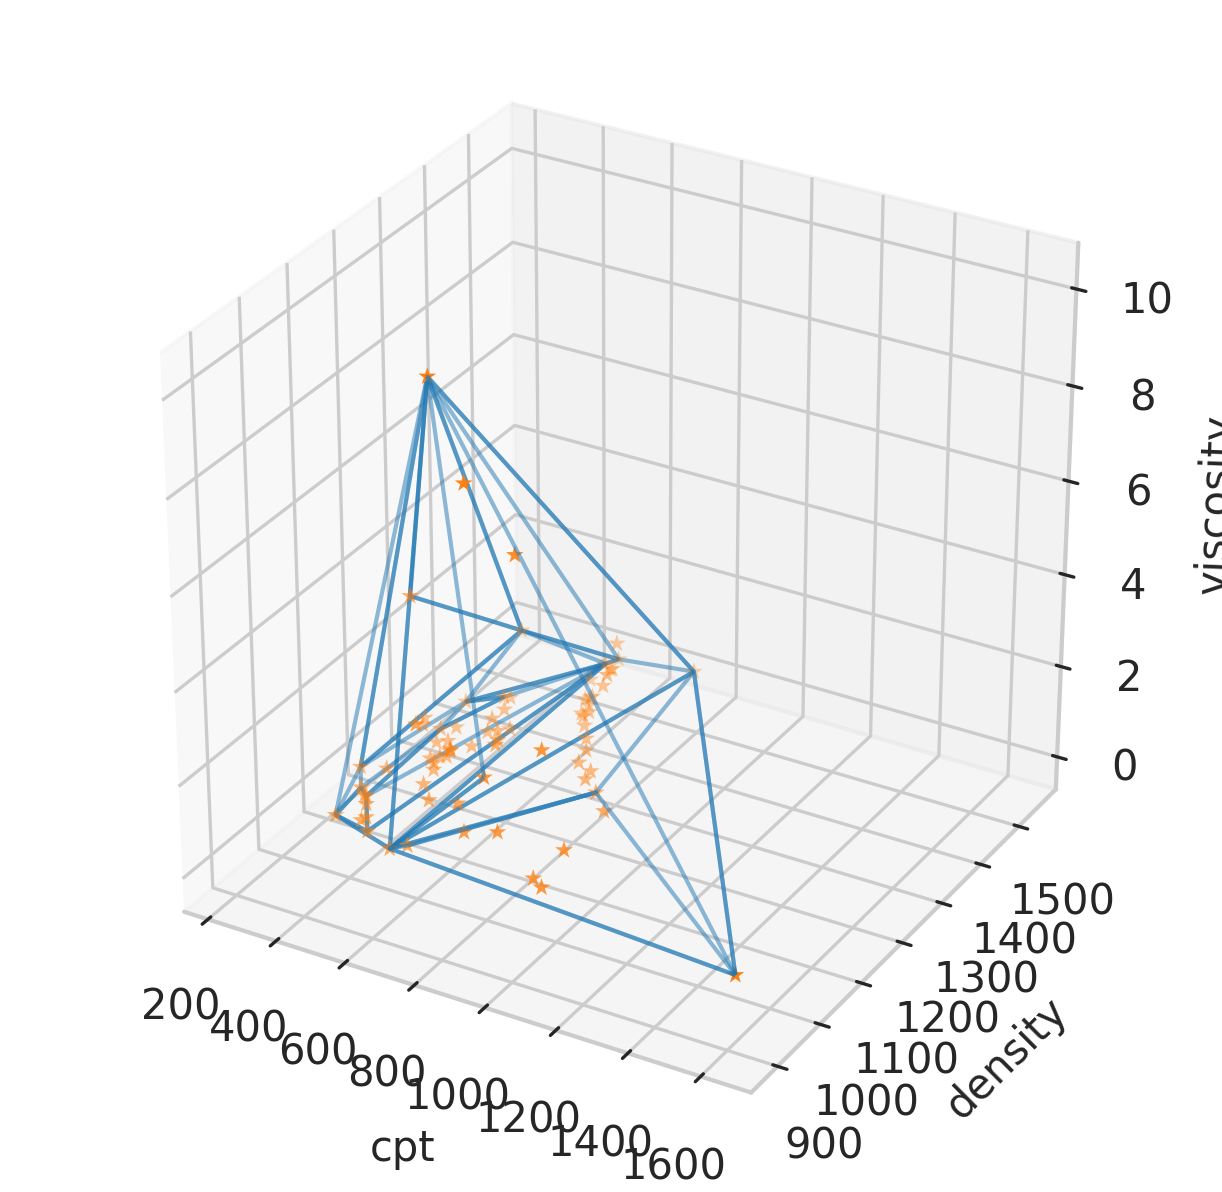

In [28]:
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(5,5), dpi=300)
    ax = fig.add_subplot(111, projection='3d')
    scat = ax.scatter(vals[2],vals[1],vals[0],linewidth=0,marker="*",
           c='tab:orange')
    for simplex in hull.simplices:
        ax.plot_wireframe(dataDf.iloc[simplex, 0], dataDf.iloc[simplex, 1], 
                Z=dataDf.iloc[simplex, 2],
               alpha=0.5, linewidth=1, linestyle="-")
    ax.set_xlabel('cpt')
    ax.set_ylabel('density')
    ax.set_zlabel('viscosity')

In [30]:
data = ['cpt', 'density'] #pull raw data from cpt.csv and density.csv
T = [298.1, 298.16] #select narrow state variable ranges
P = [101, 102] #we will set MD simulation to 101 kPa and 298 K
data = salty.aggregate_data(data,T=T,P=P)
vals, stds, size, salts = salty.merge_duplicates(data)
dataDf = pd.DataFrame([np.reshape(vals[1].values,(len(vals[1]))),
                       np.reshape(vals[0].values,(len(vals[1])))])
dataDf = dataDf.T
hull = ConvexHull(dataDf)

In [39]:
from random import randint
target_list = []
while True:
    candidate = [randint(int(np.min(vals[1])),int(np.max(vals[1]))),
                 randint(int(np.min(vals[0])),int(np.max(vals[0])))]
    df = pd.DataFrame(candidate, index=np.arange(2).reshape(2))
    df = pd.concat((dataDf, df.T))
    newhull = ConvexHull(df)
    rel_size = (newhull.area / hull.area)
    if rel_size > 1 and rel_size < 1.01:
        target_list.append(candidate)
    if len(target_list) == 10:
        break
target_list = np.array(target_list)

In [40]:
devmodel = data

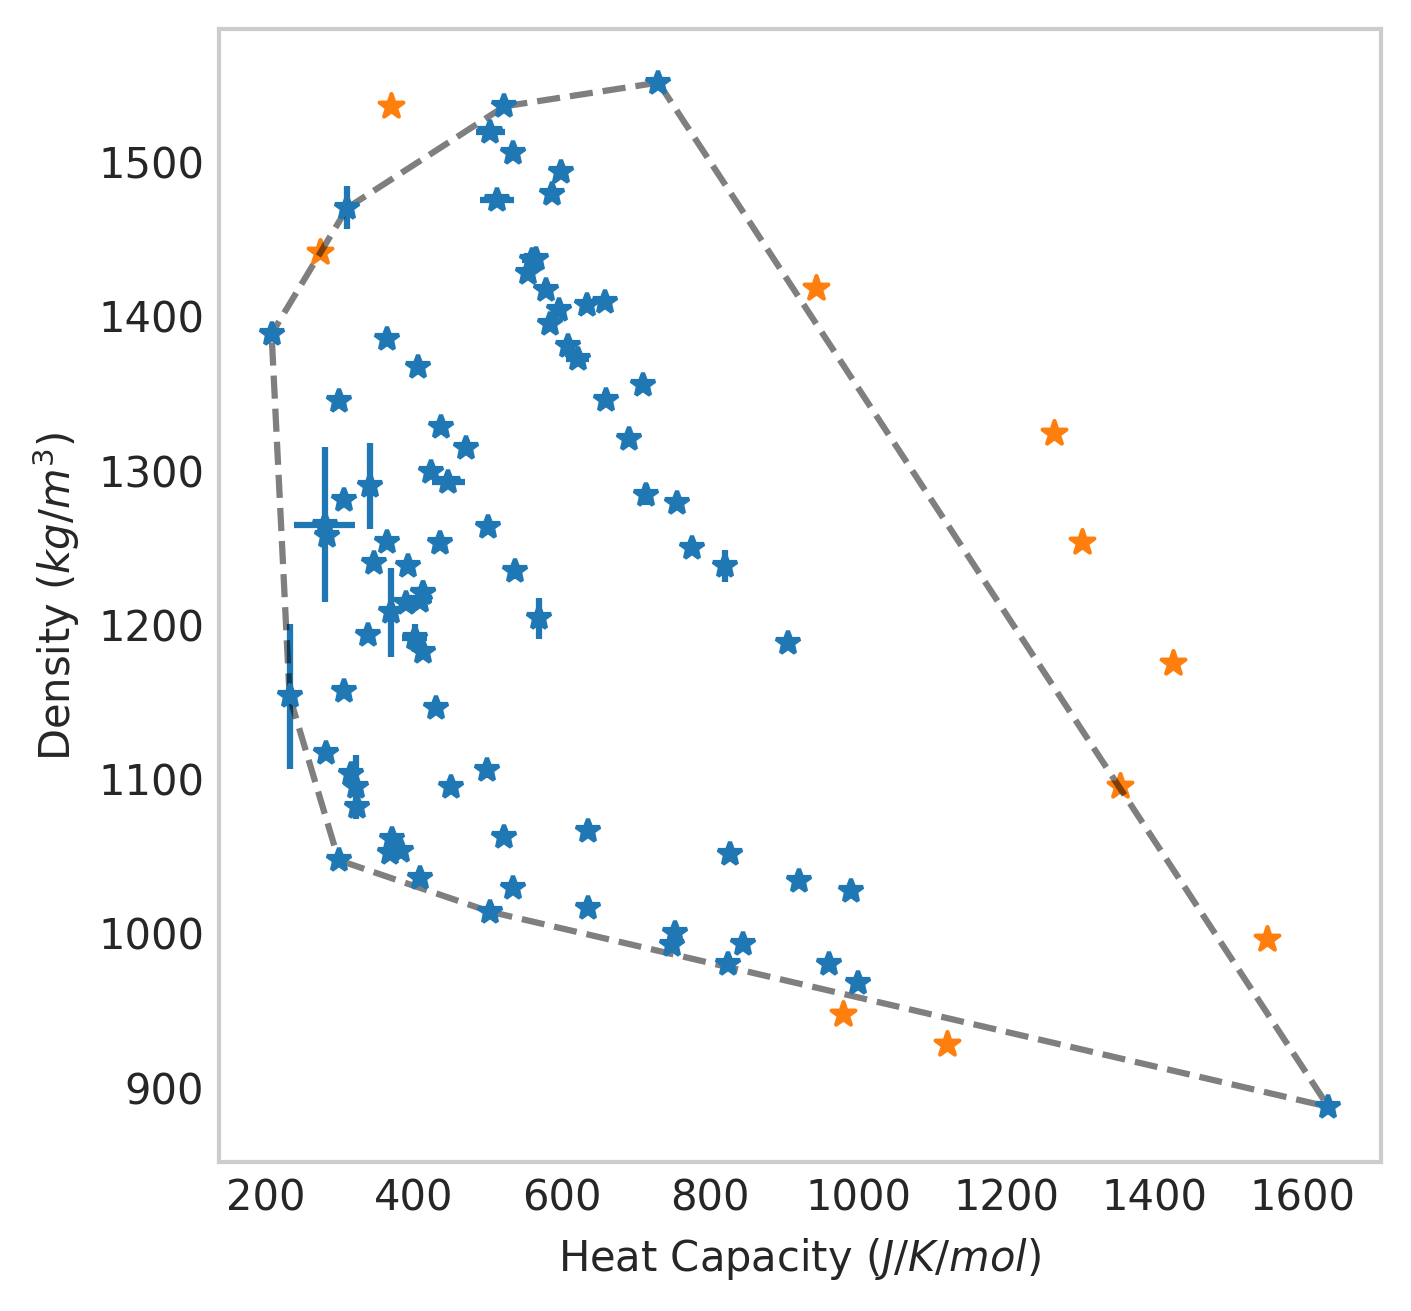

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
import pandas as pd
dataDf = pd.DataFrame([np.reshape(vals[1].values,(82)),
                       np.reshape(vals[0].values,(82))])
dataDf = dataDf.T
hull = ConvexHull(dataDf)
%matplotlib inline
df = devmodel.Data
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(5,5), dpi=300)
    ax=fig.add_subplot(111)
    scat = ax.errorbar(vals[1], vals[0], xerr=stds[1], 
                       yerr=stds[0],
        marker="*", linestyle="")
    scat = ax.scatter(y=target_list[:,1],x=target_list[:,0],marker="*",
                      c='tab:orange')
    for simplex in hull.simplices:
        ax.plot(dataDf.iloc[simplex, 0], dataDf.iloc[simplex, 1], 'k-',
               alpha=0.5, linestyle="--")
    ax.grid()
    ax.set_ylabel("Density $(kg/m^3)$")
    ax.set_xlabel("Heat Capacity $(J/K/mol)$")

In [422]:
import matplotlib.pyplot as plt
import numpy as np
import mpld3

fig, ax = plt.subplots(figsize=(10,10),subplot_kw=dict(facecolor='white'))
N = len(vals[0])

scatter = ax.scatter(vals[1],
                     vals[0],
                     s=100+100*np.log(size),
                     c=np.random.random(size=N),
                     alpha=0.3,
                     cmap=plt.cm.jet)
ax.set_ylabel("Density (kg/m3)")
ax.set_xlabel("Heat Capacity (J/K/mol)")
ax.grid(color='white', linestyle='solid')

labels = ['{}  {}'.format(salty.check_name(salts[i].split(".")[0]),
                        salty.check_name(salts[i].split(".")[1])) 
                         for i in range(N)]
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()